In [1]:
%load_ext autoreload

import math
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from last_layer_models import LLI, train_last_layer_det, get_post_pred_dens

np.random.seed(100)

# Probabilistic NNs on 1d regression

We want to visualize the predictions of different probabilistic NNs on 

$y = \sin(x) + \varepsilon$, with $\varepsilon \sim \mathcal{N}(0, \sigma_0^2)$.

## 1. Data
We sample 200 datapoints from the function with $x \in [-4,4]$. \
Then we randomly split the data into 100 points for training and validation, respectively.

Text(0.5, 1.0, 'Training/Validation split')

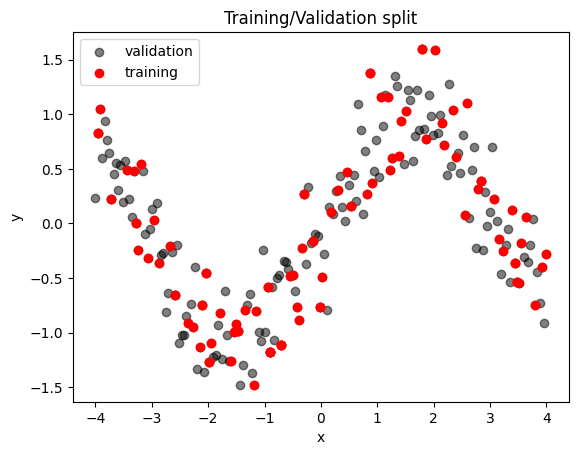

In [2]:
def f(x: float, noise: bool = True, sigma_eps: float = 0.1):
    """Generates a sample y_i from y = sin(x) + varepsilon."""
    y = math.sin(x)
    if noise:
        y += sigma_eps*np.random.randn(1)
    return y

# draw data
sigma_eps = 0.3
xs = np.linspace(-4,4,200)
ys = np.array([f(x = x, noise = True, sigma_eps = sigma_eps) for x in xs])

# sample train indices
train_idx = np.random.randint(0, len(xs), 100)

xs_train = torch.tensor(xs[train_idx]).unsqueeze(-1).float()
ys_train = torch.tensor(ys[train_idx]).float()

# visualize train/val split
fig, axs = plt.subplots(1,1)
axs.scatter(xs, ys, c = 'black', label = 'validation', alpha =.5)
axs.scatter(xs_train, ys_train, c = 'red', label = 'training', alpha = 1)
axs.legend()
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title("Training/Validation split")

Now we create the dataloaders for training and validation

In [3]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

## 2. Models
We fit three different models:
- **LLI**: last-layer inference with an isotropic Gaussian prior on $w$ and $\sigma_0^2$ is assumed to be known. This gives a closed-form posterior
- **MC dropout**: Same network as for the LLI, but with dropout layers in between the fully connected layers.
- **BNN**: full BNN trained with Bayes-by-Backprop and isotropic Gaussian priors on the weights.

In [4]:
# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 5, 1]

### 2.1 LLI

In [5]:
# train deep feature projector psi
lli_net = LLI(model_dims)
sigma_0 = sigma_eps

lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = 100)

lli_net.eval()
# fit last-layer posterior
Psi = lli_net.get_ll_embedd(xs_train)
d = Psi.shape[1]
Sigma_N_inv = (1/sigma_0**2)*torch.eye(d) + (1/sigma_eps**2)*(Psi.T @ Psi)
Sigma_N = torch.linalg.inv(Sigma_N_inv).detach()
mu_N = Sigma_N @ ((1/sigma_eps**2)*(Psi.T @ ys_train)).detach()

100%|██████████| 100/100 [00:00<00:00, 226.89it/s]


### 2.2 MC dropout

### 2.3 BNN

## 3. Visualization
We now visualize the predictive means and prediction intervals (mean + 2sd) for all models.

In [6]:
# prediction coordinates:
xs_pred_np = np.linspace(-10,10,200)

# predictions for:
# LLI:
lli_pred_mu, lli_pred_sigma = get_post_pred_dens(model = lli_net, x_star = torch.tensor(xs_pred_np).unsqueeze(-1).float() , 
                              mu_N = mu_N, Sigma_N = Sigma_N, sigma_eps = sigma_0 )
# MC dropout

# BNN

/Users/clarahoffmann/Documents/code/last_layer_inference/last-layer-inf/src/last_layer_inf/last_layer_models.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  sigma_sq_star = np.array([sigma_eps**2 + psi_star @ Sigma_N @ psi_star.T for psi_star in psi_stars])


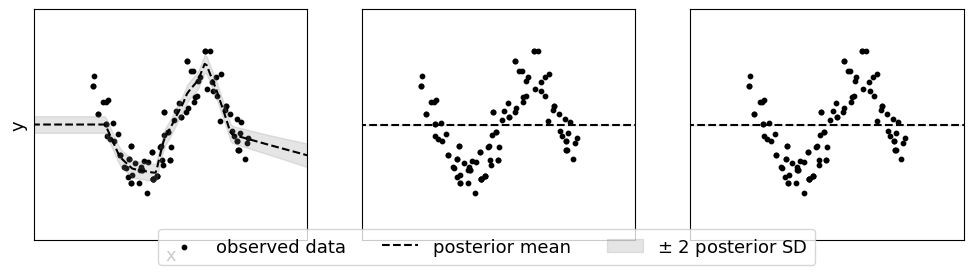

In [11]:
TEXT_SIZE = 13
ys_no_noise = np.array([f(x = x, noise = False, sigma_eps = sigma_eps) for x in xs])

fig, axs = plt.subplots(1,3,figsize=(12, 3))

for i, title, pred_mus, pred_sigmas in zip(range(3), ['LLI', 'MC dropout', 'BNN'], 
                                           [lli_pred_mu, lli_pred_mu*0, lli_pred_mu*0], 
                                           [lli_pred_sigma, lli_pred_sigma*0, lli_pred_sigma*0]):
    if i == 0:
        axs[i].scatter(xs_train, ys_train, c = 'black', label = 'observed data', alpha = 1, s = 10)
        axs[i].plot(xs_pred_np, pred_mus, c = 'black', linestyle = 'dashed', label = 'posterior mean')
        axs[i].fill_between(xs_pred_np, pred_mus - 2*pred_sigmas,  pred_mus + 2*pred_sigmas, color = 'grey', label = r'$\pm$ 2 posterior SD', alpha = 0.2)
        axs[i].set_xlabel('x', size = TEXT_SIZE)
        axs[i].set_ylabel('y', size = TEXT_SIZE)
    else: 
        axs[i].fill_between(xs_pred_np, pred_mus - 2*pred_sigmas,  pred_mus + 2*pred_sigmas, color = 'grey', alpha = 0.2)
        axs[i].plot(xs_pred_np, pred_mus, c = 'black', linestyle = 'dashed')
        axs[i].scatter(xs_train, ys_train, c = 'black', alpha = 1, s = 10)
    
    axs[i].set_xlim(-7,7)
    axs[i].set_ylim(-2.5, 2.5)
    axs[i].set_yticks([], [])
    axs[i].set_xticks([], [])


fig.legend(ncols = 3, loc='lower center', fontsize = TEXT_SIZE)
fig.savefig('1d_regression.pdf')